In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.12 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 187.4 MB 21 kB/s 
     |████████████████████████████████| 776.3 MB 17 kB/s 
     |████████████████████████████████| 57 kB 5.6 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have tor

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

# 런타임 유형 TPU로 바꾸고 이 셀을 실행

In [ ]:
# imports pytorch
import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

dev = xm.xla_device()
device = dev

# (device = dev)로 TPU 사용가능 >> to(dev)

In [2]:
!python -c "import torch; print(torch.__version__)"

1.12.1+cu113


In [ ]:
# !python -c "import torch; print(torch.version.cuda)"

11.3


https://stackoverflow.com/questions/67285115/building-wheels-for-torch-sparse-in-colab-takes-forever 

In [4]:
%%bash
pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
  Using cached torch_scatter-2.0.9.tar.gz (21 kB)
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=3861162 sha256=7e36d6daa9b072d164244f2a939c0880609ee6d29848a432d2f4e18e7c073c86
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
  Using cached torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
  Using cached torch_cluster-1.6.0.tar.gz (43

In [8]:
pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch_geometric-2.0.4-py3-none-any.whl


In [5]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 5.1 MB/s 


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [3]:
# pretrained model 불러오기
path = '/content/drive/MyDrive/pretrained/pvig_b.pth.tar'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_state_dict = torch.load(path, map_location=device)
# print(model_state_dict)

## 모델 구현

In [4]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
# modified from https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# Position embedding utils
# --------------------------------------------------------

import numpy as np

import torch

# --------------------------------------------------------
# relative position embedding
# References: https://arxiv.org/abs/2009.13658
# --------------------------------------------------------
def get_2d_relative_pos_embed(embed_dim, grid_size):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, grid_size*grid_size]
    """
    pos_embed = get_2d_sincos_pos_embed(embed_dim, grid_size)
    relative_pos = 2 * np.matmul(pos_embed, pos_embed.transpose()) / pos_embed.shape[1]
    return relative_pos


# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [5]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import math
import torch
from torch import nn
import torch.nn.functional as F


def pairwise_distance(x):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_inner = -2*torch.matmul(x, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square + x_inner + x_square.transpose(2, 1)


def part_pairwise_distance(x, start_idx=0, end_idx=1):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_part = x[:, start_idx:end_idx]
        x_square_part = torch.sum(torch.mul(x_part, x_part), dim=-1, keepdim=True)
        x_inner = -2*torch.matmul(x_part, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square_part + x_inner + x_square.transpose(2, 1)


def xy_pairwise_distance(x, y):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        xy_inner = -2*torch.matmul(x, y.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        y_square = torch.sum(torch.mul(y, y), dim=-1, keepdim=True)
        return x_square + xy_inner + y_square.transpose(2, 1)


def dense_knn_matrix(x, k=16, relative_pos=None):
    """Get KNN based on the pairwise distance.
    Args:
        x: (batch_size, num_dims, num_points, 1)
        k: int
    Returns:
        nearest neighbors: (batch_size, num_points, k) (batch_size, num_points, k)
    """
    with torch.no_grad():
        x = x.transpose(2, 1).squeeze(-1)
        batch_size, n_points, n_dims = x.shape
        ### memory efficient implementation ###
        n_part = 10000
        if n_points > n_part:
            nn_idx_list = []
            groups = math.ceil(n_points / n_part)
            for i in range(groups):
                start_idx = n_part * i
                end_idx = min(n_points, n_part * (i + 1))
                dist = part_pairwise_distance(x.detach(), start_idx, end_idx)
                if relative_pos is not None:
                    dist += relative_pos[:, start_idx:end_idx]
                _, nn_idx_part = torch.topk(-dist, k=k)
                nn_idx_list += [nn_idx_part]
            nn_idx = torch.cat(nn_idx_list, dim=1)
        else:
            dist = pairwise_distance(x.detach())
            if relative_pos is not None:
                dist += relative_pos
            _, nn_idx = torch.topk(-dist, k=k) # b, n, k
        ######
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)


def xy_dense_knn_matrix(x, y, k=16, relative_pos=None):
    """Get KNN based on the pairwise distance.
    Args:
        x: (batch_size, num_dims, num_points, 1)
        k: int
    Returns:
        nearest neighbors: (batch_size, num_points, k) (batch_size, num_points, k)
    """
    with torch.no_grad():
        x = x.transpose(2, 1).squeeze(-1)
        y = y.transpose(2, 1).squeeze(-1)
        batch_size, n_points, n_dims = x.shape
        dist = xy_pairwise_distance(x.detach(), y.detach())
        if relative_pos is not None:
            dist += relative_pos
        _, nn_idx = torch.topk(-dist, k=k)
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)


class DenseDilated(nn.Module):
    """
    Find dilated neighbor from neighbor list

    edge_index: (2, batch_size, num_points, k)
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilated, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k

    def forward(self, edge_index):
        if self.stochastic:
            if torch.rand(1) < self.epsilon and self.training:
                num = self.k * self.dilation
                randnum = torch.randperm(num)[:self.k]
                edge_index = edge_index[:, :, :, randnum]
            else:
                edge_index = edge_index[:, :, :, ::self.dilation]
        else:
            edge_index = edge_index[:, :, :, ::self.dilation]
        return edge_index


class DenseDilatedKnnGraph(nn.Module):
    """
    Find the neighbors' indices based on dilated knn
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilatedKnnGraph, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k
        self._dilated = DenseDilated(k, dilation, stochastic, epsilon)

    def forward(self, x, y=None, relative_pos=None):
        if y is not None:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            y = F.normalize(y, p=2.0, dim=1)
            ####
            edge_index = xy_dense_knn_matrix(x, y, self.k * self.dilation, relative_pos)
        else:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            ####
            edge_index = dense_knn_matrix(x, self.k * self.dilation, relative_pos)
        return self._dilated(edge_index)

In [6]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import torch
from torch import nn
from torch.nn import Sequential as Seq, Linear as Lin, Conv2d


##############################
#    Basic layers
##############################
def act_layer(act, inplace=False, neg_slope=0.2, n_prelu=1):
    # activation layer

    act = act.lower()
    if act == 'relu':
        layer = nn.ReLU(inplace)
    elif act == 'leakyrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    elif act == 'gelu':
        layer = nn.GELU()
    elif act == 'hswish':
        layer = nn.Hardswish(inplace)
    else:
        raise NotImplementedError('activation layer [%s] is not found' % act)
    return layer


def norm_layer(norm, nc):
    # normalization layer 2d
    norm = norm.lower()
    if norm == 'batch':
        layer = nn.BatchNorm2d(nc, affine=True)
    elif norm == 'instance':
        layer = nn.InstanceNorm2d(nc, affine=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm)
    return layer


class MLP(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True):
        m = []
        for i in range(1, len(channels)):
            m.append(Lin(channels[i - 1], channels[i], bias))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
        super(MLP, self).__init__(*m)


class BasicConv(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True, drop=0.):
        m = []
        for i in range(1, len(channels)):
            m.append(Conv2d(channels[i - 1], channels[i], 1, bias=bias, groups=4))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if drop > 0:
                m.append(nn.Dropout2d(drop))

        super(BasicConv, self).__init__(*m)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def batched_index_select(x, idx):
    r"""fetches neighbors features from a given neighbor idx

    Args:
        x (Tensor): input feature Tensor
                :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times 1}`.
        idx (Tensor): edge_idx
                :math:`\mathbf{X} \in \mathbb{R}^{B \times N \times l}`.
    Returns:
        Tensor: output neighbors features
            :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times k}`.
    """
    batch_size, num_dims, num_vertices_reduced = x.shape[:3]
    _, num_vertices, k = idx.shape
    idx_base = torch.arange(0, batch_size, device=idx.device).view(-1, 1, 1) * num_vertices_reduced
    idx = idx + idx_base
    idx = idx.contiguous().view(-1)

    x = x.transpose(2, 1)
    feature = x.contiguous().view(batch_size * num_vertices_reduced, -1)[idx, :]
    feature = feature.view(batch_size, num_vertices, k, num_dims).permute(0, 3, 1, 2).contiguous()
    return feature

In [7]:
# 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
import numpy as np
import torch
from torch import nn
# from .torch_nn import BasicConv, batched_index_select, act_layer
# from .torch_edge import DenseDilatedKnnGraph
# from .pos_embed import get_2d_relative_pos_embed
import torch.nn.functional as F
from timm.models.layers import DropPath


class MRConv2d(nn.Module):
    """
    Max-Relative Graph Convolution (Paper: https://arxiv.org/abs/1904.03751) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(MRConv2d, self).__init__()
        self.nn = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(x_j - x_i, -1, keepdim=True)
        b, c, n, _ = x.shape
        x = torch.cat([x.unsqueeze(2), x_j.unsqueeze(2)], dim=2).reshape(b, 2 * c, n, _)
        return self.nn(x)


class EdgeConv2d(nn.Module):
    """
    Edge convolution layer (with activation, batch normalization) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(EdgeConv2d, self).__init__()
        self.nn = BasicConv([in_channels * 2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        max_value, _ = torch.max(self.nn(torch.cat([x_i, x_j - x_i], dim=1)), -1, keepdim=True)
        return max_value


class GraphSAGE(nn.Module):
    """
    GraphSAGE Graph Convolution (Paper: https://arxiv.org/abs/1706.02216) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GraphSAGE, self).__init__()
        self.nn1 = BasicConv([in_channels, in_channels], act, norm, bias)
        self.nn2 = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(self.nn1(x_j), -1, keepdim=True)
        return self.nn2(torch.cat([x, x_j], dim=1))


class GINConv2d(nn.Module):
    """
    GIN Graph Convolution (Paper: https://arxiv.org/abs/1810.00826) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GINConv2d, self).__init__()
        self.nn = BasicConv([in_channels, out_channels], act, norm, bias)
        eps_init = 0.0
        self.eps = nn.Parameter(torch.Tensor([eps_init]))

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j = torch.sum(x_j, -1, keepdim=True)
        return self.nn((1 + self.eps) * x + x_j)


class GraphConv2d(nn.Module):
    """
    Static graph convolution layer
    """
    def __init__(self, in_channels, out_channels, conv='edge', act='relu', norm=None, bias=True):
        super(GraphConv2d, self).__init__()
        if conv == 'edge':
            self.gconv = EdgeConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'mr':
            self.gconv = MRConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'sage':
            self.gconv = GraphSAGE(in_channels, out_channels, act, norm, bias)
        elif conv == 'gin':
            self.gconv = GINConv2d(in_channels, out_channels, act, norm, bias)
        else:
            raise NotImplementedError('conv:{} is not supported'.format(conv))

    def forward(self, x, edge_index, y=None):
        return self.gconv(x, edge_index, y)


class DyGraphConv2d(GraphConv2d):
    """
    Dynamic graph convolution layer
    """
    def __init__(self, in_channels, out_channels, kernel_size=9, dilation=1, conv='edge', act='relu',
                 norm=None, bias=True, stochastic=False, epsilon=0.0, r=1):
        super(DyGraphConv2d, self).__init__(in_channels, out_channels, conv, act, norm, bias)
        self.k = kernel_size
        self.d = dilation
        self.r = r
        self.dilated_knn_graph = DenseDilatedKnnGraph(kernel_size, dilation, stochastic, epsilon)

    def forward(self, x, relative_pos=None):
        B, C, H, W = x.shape
        y = None
        if self.r > 1:
            y = F.avg_pool2d(x, self.r, self.r)
            y = y.reshape(B, C, -1, 1).contiguous()            
        x = x.reshape(B, C, -1, 1).contiguous()
        edge_index = self.dilated_knn_graph(x, y, relative_pos)
        x = super(DyGraphConv2d, self).forward(x, edge_index, y)
        return x.reshape(B, -1, H, W).contiguous()


class Grapher(nn.Module):
    """
    Grapher module with graph convolution and fc layers
    """
    def __init__(self, in_channels, kernel_size=9, dilation=1, conv='edge', act='relu', norm=None,
                 bias=True,  stochastic=False, epsilon=0.0, r=1, n=196, drop_path=0.0, relative_pos=False):
        super(Grapher, self).__init__()
        self.channels = in_channels
        self.n = n
        self.r = r
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = DyGraphConv2d(in_channels, in_channels * 2, kernel_size, dilation, conv,
                              act, norm, bias, stochastic, epsilon, r)
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.relative_pos = None
        if relative_pos:
            print('using relative_pos')
            relative_pos_tensor = torch.from_numpy(np.float32(get_2d_relative_pos_embed(in_channels,
                int(n**0.5)))).unsqueeze(0).unsqueeze(1)
            relative_pos_tensor = F.interpolate(
                    relative_pos_tensor, size=(n, n//(r*r)), mode='bicubic', align_corners=False)
            self.relative_pos = nn.Parameter(-relative_pos_tensor.squeeze(1), requires_grad=False)

    def _get_relative_pos(self, relative_pos, H, W):
        if relative_pos is None or H * W == self.n:
            return relative_pos
        else:
            N = H * W
            N_reduced = N // (self.r * self.r)
            return F.interpolate(relative_pos.unsqueeze(0), size=(N, N_reduced), mode="bicubic").squeeze(0)

    def forward(self, x):
        _tmp = x
        x = self.fc1(x)
        B, C, H, W = x.shape
        relative_pos = self._get_relative_pos(self.relative_pos, H, W)
        x = self.graph_conv(x, relative_pos)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x

In [8]:
## 2022.06.17-Changed for building ViG model
#            Huawei Technologies Co., Ltd. <foss@huawei.com>
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

# from gcn_lib import Grapher, act_layer


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'vig_224_gelu': _cfg(
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vig_b_224_gelu': _cfg(
        crop_pct=0.95, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
}


class FFN(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act='relu', drop_path=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x#.reshape(B, C, N, 1)


class Stem(nn.Module):
    """ Image to Visual Embedding
    Overlap: https://arxiv.org/pdf/2106.13797.pdf
    """
    def __init__(self, img_size=224, in_dim=3, out_dim=768, act='relu'):
        super().__init__()        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.Conv2d(out_dim//2, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            act_layer(act),
            nn.Conv2d(out_dim, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.convs(x)
        return x


class Downsample(nn.Module):
    """ Convolution-based downsample
    """
    def __init__(self, in_dim=3, out_dim=768):
        super().__init__()        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class DeepGCN(torch.nn.Module):
    def __init__(self, opt):
        super(DeepGCN, self).__init__()
        print(opt)
        k = opt.k
        act = opt.act
        norm = opt.norm
        bias = opt.bias
        epsilon = opt.epsilon
        stochastic = opt.use_stochastic
        conv = opt.conv
        emb_dims = opt.emb_dims
        drop_path = opt.drop_path
        
        blocks = opt.blocks
        self.n_blocks = sum(blocks)
        channels = opt.channels
        reduce_ratios = [4, 2, 1, 1]
        dpr = [x.item() for x in torch.linspace(0, drop_path, self.n_blocks)]  # stochastic depth decay rule 
        num_knn = [int(x.item()) for x in torch.linspace(k, k, self.n_blocks)]  # number of knn's k
        max_dilation = 49 // max(num_knn)
        
        self.stem = Stem(out_dim=channels[0], act=act)
        self.pos_embed = nn.Parameter(torch.zeros(1, channels[0], 224//4, 224//4))
        HW = 224 // 4 * 224 // 4

        self.backbone = nn.ModuleList([])
        idx = 0
        for i in range(len(blocks)):
            if i > 0:
                self.backbone.append(Downsample(channels[i-1], channels[i]))
                HW = HW // 4
            for j in range(blocks[i]):
                self.backbone += [
                    Seq(Grapher(channels[i], num_knn[idx], min(idx // 4 + 1, max_dilation), conv, act, norm,
                                    bias, stochastic, epsilon, reduce_ratios[i], n=HW, drop_path=dpr[idx],
                                    relative_pos=True),
                          FFN(channels[i], channels[i] * 4, act=act, drop_path=dpr[idx])
                         )]
                idx += 1
        self.backbone = Seq(*self.backbone)

        self.prediction = Seq(nn.Conv2d(channels[-1], 1024, 1, bias=True),
                              nn.BatchNorm2d(1024),
                              act_layer(act),
                              nn.Dropout(opt.dropout),
                              nn.Conv2d(1024, opt.n_classes, 1, bias=True))
        self.model_init()

    def model_init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, inputs):
        x = self.stem(inputs) + self.pos_embed
        B, C, H, W = x.shape
        for i in range(len(self.backbone)):
            x = self.backbone[i](x)

        x = F.adaptive_avg_pool2d(x, 1)
        return self.prediction(x).squeeze(-1).squeeze(-1)


@register_model
def pvig_ti_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [48, 96, 240, 384] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_s_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,6,2] # number of basic blocks in the backbone
            self.channels = [80, 160, 400, 640] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_m_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,16,2] # number of basic blocks in the backbone
            self.channels = [96, 192, 384, 768] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model


@register_model
def pvig_b_224(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=1000, drop_path_rate=0.0, **kwargs):
            self.k = 9 # neighbor num (default:9)
            self.conv = 'mr' # graph conv layer {edge, mr}
            self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
            self.norm = 'batch' # batch or instance normalization {batch, instance}
            self.bias = True # bias of conv layer True or False
            self.dropout = 0.0 # dropout rate
            self.use_dilation = True # use dilated knn or not
            self.epsilon = 0.2 # stochastic epsilon for gcn
            self.use_stochastic = False # stochastic for gcn, True or False
            self.drop_path = drop_path_rate
            self.blocks = [2,2,18,2] # number of basic blocks in the backbone
            self.channels = [128, 256, 512, 1024] # number of channels of deep features
            self.n_classes = num_classes # Dimension of out_channels
            self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_b_224_gelu']
    return model

## 모델 초기화, 옵티마이저 정의 등등

In [10]:
model = pvig_b_224()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

<__main__.pvig_b_224.<locals>.OptInit object at 0x7f47bed1db50>
using relative_pos
using relative_pos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos


In [9]:
# model.load_state_dict(model_state_dict)

In [ ]:
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
for var_name in optimizer.state_dict():
  print(var_name, "\t", optimizer.state_dict()[var_name])

In [11]:
from torchsummary import summary

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              GELU-3         [-1, 64, 112, 112]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
       BatchNorm2d-5          [-1, 128, 56, 56]             256
              GELU-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]         147,584
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              Stem-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]          16,512
      BatchNorm2d-11          [-1, 128, 56, 56]             256
     DenseDilated-12           [-1, 2, 3136, 9]               0
DenseDilatedKnnGraph-13           [-1, 2, 3136, 9]               0
           Conv2d-14         [-1, 25

## 01. FruitAndVegetable 데이터셋 실험

In [12]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
# from email.mime import image


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/MyDrive/Data/FruitAndVegetables/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print(len(image_datasets['train']))
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

# device = dev

3115


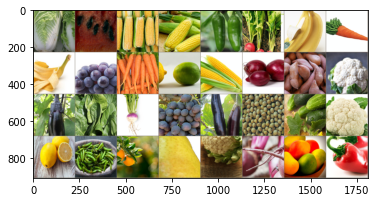

['cabbage', 'watermelon', 'corn', 'sweetcorn', 'chilli pepper', 'raddish', 'banana', 'carrot', 'banana', 'grapes', 'carrot', 'lemon', 'corn', 'onion', 'sweetpotato', 'cauliflower', 'eggplant', 'spinach', 'turnip', 'grapes', 'eggplant', 'soy beans', 'cucumber', 'cauliflower', 'lemon', 'peas', 'orange', 'pear', 'cauliflower', 'beetroot', 'mango', 'chilli pepper']


In [18]:
# transform 된 배치 이미지 시각화
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out)
print([class_names[x] for x in classes])

In [20]:
!pip install tensorboardX
!pip install tensorboard 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from tqdm import tqdm
# from tensorboardX import SummaryWriter

# writer = SummaryWriter()

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # print(f"time per 1 epoch: {time.time() - since:.2f}")

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                # model.load_state_dict(model_state_dict)
                model.train()  # 모델을 학습 모드로 설정
            else:
                # model.load_state_dict(model_state_dict)
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # writer.add_scalar("Loss/train", epoch_loss, epoch)
            # writer.add_scalar("Acc/train", epoch_acc, epoch)
            # wandb.log({'train_acc': epoch_acc, 'train_loss' : epoch_loss})

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print('Update best acc ! : ', best_acc)
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        time.sleep(0.1)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    # wandb.log({'test_acc': best_acc})
    

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [14]:
# model = ViG-B
import gc
gc.collect()
torch.cuda.empty_cache()

train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 5.0997 Acc: 0.1393
val Loss: 2.8952 Acc: 0.3315



  5%|▌         | 1/20 [04:52<1:32:33, 292.31s/it]

Epoch 1/19
----------
train Loss: 3.0622 Acc: 0.2825
val Loss: 2.0582 Acc: 0.4652



 10%|█         | 2/20 [09:40<1:27:02, 290.16s/it]

Epoch 2/19
----------
train Loss: 2.6150 Acc: 0.3297


 15%|█▌        | 3/20 [14:29<1:22:02, 289.59s/it]

val Loss: 1.6042 Acc: 0.5487

Epoch 3/19
----------
train Loss: 2.3515 Acc: 0.3743


 20%|██        | 4/20 [19:18<1:17:04, 289.04s/it]

val Loss: 1.4246 Acc: 0.6295

Epoch 4/19
----------
train Loss: 2.1958 Acc: 0.3994


 25%|██▌       | 5/20 [24:03<1:11:57, 287.81s/it]

val Loss: 1.2873 Acc: 0.6184

Epoch 5/19
----------
train Loss: 2.0268 Acc: 0.4327
val Loss: 1.1783 Acc: 0.6435



 30%|███       | 6/20 [28:49<1:06:59, 287.13s/it]

Epoch 6/19
----------
train Loss: 1.9399 Acc: 0.4433


 35%|███▌      | 7/20 [33:36<1:02:10, 286.96s/it]

val Loss: 1.1004 Acc: 0.6825

Epoch 7/19
----------
train Loss: 1.8823 Acc: 0.4465


 40%|████      | 8/20 [38:23<57:23, 286.96s/it]  

val Loss: 1.0157 Acc: 0.7187

Epoch 8/19
----------
train Loss: 1.8276 Acc: 0.4632


 45%|████▌     | 9/20 [43:10<52:37, 287.03s/it]

val Loss: 0.9962 Acc: 0.7326

Epoch 9/19
----------
train Loss: 1.7451 Acc: 0.4873


 50%|█████     | 10/20 [47:58<47:54, 287.47s/it]

val Loss: 0.8494 Acc: 0.7632

Epoch 10/19
----------
train Loss: 1.5918 Acc: 0.5422
val Loss: 0.7854 Acc: 0.7883



 55%|█████▌    | 11/20 [52:51<43:22, 289.16s/it]

Epoch 11/19
----------
train Loss: 1.5342 Acc: 0.5544


 60%|██████    | 12/20 [57:47<38:48, 291.03s/it]

val Loss: 0.7727 Acc: 0.7994

Epoch 12/19
----------
train Loss: 1.5134 Acc: 0.5570
val Loss: 0.7612 Acc: 0.8050



 65%|██████▌   | 13/20 [1:02:39<34:01, 291.62s/it]

Epoch 13/19
----------
train Loss: 1.5037 Acc: 0.5637


 70%|███████   | 14/20 [1:07:30<29:08, 291.34s/it]

val Loss: 0.7487 Acc: 0.8050

Epoch 14/19
----------
train Loss: 1.4606 Acc: 0.5669
val Loss: 0.7409 Acc: 0.8078



 75%|███████▌  | 15/20 [1:12:25<24:21, 292.36s/it]

Epoch 15/19
----------
train Loss: 1.4658 Acc: 0.5769


 80%|████████  | 16/20 [1:17:18<19:30, 292.57s/it]

val Loss: 0.7373 Acc: 0.8050

Epoch 16/19
----------
train Loss: 1.4702 Acc: 0.5759
val Loss: 0.7248 Acc: 0.8217



 85%|████████▌ | 17/20 [1:22:17<14:43, 294.59s/it]

Epoch 17/19
----------
train Loss: 1.4412 Acc: 0.5804


 90%|█████████ | 18/20 [1:27:15<09:51, 295.54s/it]

val Loss: 0.7292 Acc: 0.8162

Epoch 18/19
----------
train Loss: 1.4352 Acc: 0.5971


 95%|█████████▌| 19/20 [1:32:08<04:54, 294.82s/it]

val Loss: 0.7096 Acc: 0.8245

Epoch 19/19
----------
train Loss: 1.4405 Acc: 0.5839


100%|██████████| 20/20 [1:36:56<00:00, 290.84s/it]

val Loss: 0.6795 Acc: 0.8245

Training complete in 96m 57s
Best val Acc: 0.824513


DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate=none)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate=none)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Grapher(
        (fc1): Sequential(
          (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (graph_conv): DyGraphConv2d(
          (gconv): MRConv2d(
            (nn): BasicConv(
  

In [19]:
# model = ViG-ti
import gc
gc.collect()
torch.cuda.empty_cache()

model = pvig_ti_224()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

print(summary(model, (3,224,224)))
train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

<__main__.pvig_ti_224.<locals>.OptInit object at 0x7f478a287f10>
using relative_pos
using relative_pos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             672
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              GELU-3         [-1, 24, 112, 112]               0
            Conv2d-4           [-1, 48, 56, 56]          10,416
       BatchNorm2d-5           [-1, 48, 56, 56]              96
              GELU-6           [-1, 48, 56, 56]               0
            Conv2d-7           [-1, 48, 56, 56]          20,784
       BatchNorm2d-8           [-1, 48, 56, 56]              96
              Stem-9           [-1, 48, 56, 56]               0
           Conv2d-10           [-1, 48, 56, 56]           2,352
      BatchNorm2d-11           [-1, 48, 5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 6.3154 Acc: 0.0591


  5%|▌         | 1/20 [03:26<1:05:19, 206.27s/it]

val Loss: 4.7279 Acc: 0.2061

Epoch 1/19
----------
train Loss: 4.3561 Acc: 0.2019


 10%|█         | 2/20 [07:00<1:03:21, 211.19s/it]

val Loss: 3.2858 Acc: 0.3370

Epoch 2/19
----------
train Loss: 3.3976 Acc: 0.2770


 15%|█▌        | 3/20 [10:34<1:00:07, 212.18s/it]

val Loss: 2.5760 Acc: 0.4123

Epoch 3/19
----------
train Loss: 2.9376 Acc: 0.3217


 20%|██        | 4/20 [14:03<56:13, 210.87s/it]  

val Loss: 2.2275 Acc: 0.4345

Epoch 4/19
----------
train Loss: 2.7141 Acc: 0.3403


 25%|██▌       | 5/20 [17:29<52:19, 209.31s/it]

val Loss: 2.0835 Acc: 0.4513

Epoch 5/19
----------
train Loss: 2.5048 Acc: 0.3589


 30%|███       | 6/20 [21:06<49:26, 211.87s/it]

val Loss: 1.7995 Acc: 0.5404

Epoch 6/19
----------
train Loss: 2.4041 Acc: 0.3657


 35%|███▌      | 7/20 [24:43<46:17, 213.64s/it]

val Loss: 1.7261 Acc: 0.5265

Epoch 7/19
----------
train Loss: 2.2822 Acc: 0.3945


 40%|████      | 8/20 [28:19<42:50, 214.17s/it]

val Loss: 1.6186 Acc: 0.5543

Epoch 8/19
----------
train Loss: 2.2147 Acc: 0.3965


 45%|████▌     | 9/20 [31:50<39:07, 213.39s/it]

val Loss: 1.5230 Acc: 0.5655

Epoch 9/19
----------
train Loss: 2.1539 Acc: 0.4051


 50%|█████     | 10/20 [35:25<35:39, 213.94s/it]

val Loss: 1.4572 Acc: 0.5850

Epoch 10/19
----------
train Loss: 2.0477 Acc: 0.4347


 55%|█████▌    | 11/20 [38:57<31:58, 213.15s/it]

val Loss: 1.3874 Acc: 0.6295

Epoch 11/19
----------
train Loss: 2.0189 Acc: 0.4488


 60%|██████    | 12/20 [42:24<28:11, 211.40s/it]

val Loss: 1.3684 Acc: 0.6462

Epoch 12/19
----------
train Loss: 1.9999 Acc: 0.4398


 65%|██████▌   | 13/20 [45:56<24:39, 211.39s/it]

val Loss: 1.3529 Acc: 0.6212

Epoch 13/19
----------
train Loss: 1.9719 Acc: 0.4565


 70%|███████   | 14/20 [49:26<21:07, 211.20s/it]

val Loss: 1.3606 Acc: 0.6379

Epoch 14/19
----------
train Loss: 1.9929 Acc: 0.4501


 75%|███████▌  | 15/20 [52:59<17:38, 211.61s/it]

val Loss: 1.3578 Acc: 0.6435

Epoch 15/19
----------
train Loss: 1.9649 Acc: 0.4639


 80%|████████  | 16/20 [56:30<14:05, 211.33s/it]

val Loss: 1.3437 Acc: 0.6295

Epoch 16/19
----------
train Loss: 1.9695 Acc: 0.4510


 85%|████████▌ | 17/20 [59:59<10:32, 210.83s/it]

val Loss: 1.3390 Acc: 0.6518

Epoch 17/19
----------
train Loss: 1.9300 Acc: 0.4616


 90%|█████████ | 18/20 [1:03:29<07:01, 210.55s/it]

val Loss: 1.3453 Acc: 0.6295

Epoch 18/19
----------
train Loss: 1.9415 Acc: 0.4665


 95%|█████████▌| 19/20 [1:06:59<03:30, 210.24s/it]

val Loss: 1.3206 Acc: 0.6462

Epoch 19/19
----------
train Loss: 1.9465 Acc: 0.4501


100%|██████████| 20/20 [1:10:27<00:00, 211.38s/it]

val Loss: 1.2867 Acc: 0.6351

Training complete in 70m 28s
Best val Acc: 0.651811


DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate=none)
      (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate=none)
      (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Grapher(
        (fc1): Sequential(
          (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (graph_conv): DyGraphConv2d(
          (gconv): MRConv2d(
            (nn): BasicConv(
          

In [22]:
# model = ViG-S
import gc
gc.collect()
torch.cuda.empty_cache()

model = pvig_s_224()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

print(summary(model, (3,224,224)))

train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

<__main__.pvig_s_224.<locals>.OptInit object at 0x7f4731132850>
using relative_pos
using relative_pos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,120
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              GELU-3         [-1, 40, 112, 112]               0
            Conv2d-4           [-1, 80, 56, 56]          28,880
       BatchNorm2d-5           [-1, 80, 56, 56]             160
              GELU-6           [-1, 80, 56, 56]               0
            Conv2d-7           [-1, 80, 56, 56]          57,680
       BatchNorm2d-8           [-1, 80, 56, 56]             160
              Stem-9           [-1, 80, 56, 56]               0
           Conv2d-10           [-1, 80, 56, 56]           6,480
      BatchNorm2d-11           [-1, 80, 5

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 5.1335 Acc: 0.1477


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  5%|▌         | 1/20 [01:54<36:14, 114.47s/it]

val Loss: 3.1580 Acc: 0.3008

Epoch 1/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 3.1312 Acc: 0.2719


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 10%|█         | 2/20 [03:49<34:23, 114.66s/it]

val Loss: 2.0522 Acc: 0.4540

Epoch 2/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 2.6710 Acc: 0.3281


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 15%|█▌        | 3/20 [05:43<32:27, 114.59s/it]

val Loss: 1.7725 Acc: 0.5292

Epoch 3/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.4744 Acc: 0.3438


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 20%|██        | 4/20 [07:37<30:27, 114.23s/it]

val Loss: 1.5776 Acc: 0.5655

Epoch 4/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.3071 Acc: 0.3743


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 25%|██▌       | 5/20 [09:31<28:34, 114.32s/it]

val Loss: 1.4520 Acc: 0.6240

Epoch 5/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.2010 Acc: 0.3926


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 30%|███       | 6/20 [11:26<26:39, 114.24s/it]

val Loss: 1.3735 Acc: 0.5766

Epoch 6/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.0902 Acc: 0.4170


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 35%|███▌      | 7/20 [13:23<24:59, 115.38s/it]

val Loss: 1.4068 Acc: 0.5877

Epoch 7/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.9935 Acc: 0.4244


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 40%|████      | 8/20 [15:22<23:16, 116.41s/it]

val Loss: 1.1919 Acc: 0.6713

Epoch 8/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.9313 Acc: 0.4395


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 45%|████▌     | 9/20 [17:16<21:11, 115.61s/it]

val Loss: 1.1955 Acc: 0.6462

Epoch 9/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.8434 Acc: 0.4748


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 50%|█████     | 10/20 [19:11<19:14, 115.48s/it]

val Loss: 1.1316 Acc: 0.6741

Epoch 10/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.7339 Acc: 0.4986


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 55%|█████▌    | 11/20 [21:08<17:24, 116.00s/it]

val Loss: 0.9804 Acc: 0.7632

Epoch 11/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6589 Acc: 0.5197


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 60%|██████    | 12/20 [23:09<15:41, 117.64s/it]

val Loss: 0.9599 Acc: 0.7465

Epoch 12/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6480 Acc: 0.5143


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 65%|██████▌   | 13/20 [25:06<13:41, 117.30s/it]

val Loss: 0.9549 Acc: 0.7827

Epoch 13/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6370 Acc: 0.5281


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 70%|███████   | 14/20 [27:04<11:45, 117.64s/it]

val Loss: 0.9346 Acc: 0.7577

Epoch 14/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5991 Acc: 0.5470


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 75%|███████▌  | 15/20 [29:00<09:45, 117.01s/it]

val Loss: 0.9471 Acc: 0.7744

Epoch 15/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6181 Acc: 0.5335


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 80%|████████  | 16/20 [30:54<07:45, 116.27s/it]

val Loss: 0.9202 Acc: 0.7604

Epoch 16/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5981 Acc: 0.5393


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 85%|████████▌ | 17/20 [32:54<05:51, 117.12s/it]

val Loss: 0.9097 Acc: 0.7716

Epoch 17/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5893 Acc: 0.5396


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 90%|█████████ | 18/20 [34:57<03:58, 119.11s/it]

val Loss: 0.9002 Acc: 0.7688

Epoch 18/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.5994 Acc: 0.5451


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 95%|█████████▌| 19/20 [36:53<01:58, 118.06s/it]

val Loss: 0.9007 Acc: 0.7632

Epoch 19/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 1.6066 Acc: 0.5226


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 20/20 [38:49<00:00, 116.46s/it]

val Loss: 0.8874 Acc: 0.7549

Training complete in 38m 49s
Best val Acc: 0.782730


DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate=none)
      (3): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate=none)
      (6): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Grapher(
        (fc1): Sequential(
          (0): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (graph_conv): DyGraphConv2d(
          (gconv): MRConv2d(
            (nn): BasicConv(
          

In [ ]:
# tensorboard --logdir runs

In [24]:
# model = ViG-M
import gc
gc.collect()
torch.cuda.empty_cache()

model = pvig_m_224()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.95)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

print(summary(model, (3,224,224)))

train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

<__main__.pvig_m_224.<locals>.OptInit object at 0x7f473116c050>
using relative_pos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,344
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              GELU-3         [-1, 48, 112, 112]               0
            Conv2d-4           [-1, 96, 56, 56]          41,568
       BatchNorm2d-5           [-1, 96, 56, 56]             192
              GELU-6           [-1, 96, 56, 56]               0
            Conv2d-7           [-1, 96, 56, 56]          83,040
       BatchNorm2d-8    

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 5.3540 Acc: 0.1265


  5%|▌         | 1/20 [04:19<1:22:01, 259.01s/it]

val Loss: 3.1773 Acc: 0.3259

Epoch 1/19
----------
train Loss: 3.2194 Acc: 0.2591


 10%|█         | 2/20 [08:36<1:17:22, 257.93s/it]

val Loss: 2.1101 Acc: 0.4234

Epoch 2/19
----------
train Loss: 2.6461 Acc: 0.3220


 15%|█▌        | 3/20 [12:51<1:12:46, 256.84s/it]

val Loss: 1.8036 Acc: 0.4986

Epoch 3/19
----------
train Loss: 2.3853 Acc: 0.3445


 20%|██        | 4/20 [17:02<1:07:51, 254.49s/it]

val Loss: 1.6009 Acc: 0.5515

Epoch 4/19
----------
train Loss: 2.2757 Acc: 0.3666


 25%|██▌       | 5/20 [21:12<1:03:13, 252.87s/it]

val Loss: 1.4484 Acc: 0.6017

Epoch 5/19
----------
train Loss: 2.1492 Acc: 0.3945


 30%|███       | 6/20 [25:23<58:48, 252.03s/it]  

val Loss: 1.2956 Acc: 0.6462

Epoch 6/19
----------
train Loss: 2.0421 Acc: 0.4119


 35%|███▌      | 7/20 [29:38<54:52, 253.29s/it]

val Loss: 1.2220 Acc: 0.6685

Epoch 7/19
----------
train Loss: 1.9872 Acc: 0.4340


 40%|████      | 8/20 [33:56<50:57, 254.80s/it]

val Loss: 1.0790 Acc: 0.6852

Epoch 8/19
----------
train Loss: 1.8731 Acc: 0.4591


 45%|████▌     | 9/20 [38:14<46:50, 255.52s/it]

val Loss: 1.0437 Acc: 0.7382

Epoch 9/19
----------
train Loss: 1.8209 Acc: 0.4806


 50%|█████     | 10/20 [42:31<42:40, 256.00s/it]

val Loss: 1.0186 Acc: 0.7270

Epoch 10/19
----------
train Loss: 1.6418 Acc: 0.5136


 55%|█████▌    | 11/20 [46:47<38:26, 256.24s/it]

val Loss: 0.9203 Acc: 0.7632

Epoch 11/19
----------
train Loss: 1.5840 Acc: 0.5368


 60%|██████    | 12/20 [51:03<34:09, 256.14s/it]

val Loss: 0.8796 Acc: 0.7688

Epoch 12/19
----------
train Loss: 1.5985 Acc: 0.5345


 65%|██████▌   | 13/20 [55:19<29:51, 255.89s/it]

val Loss: 0.8938 Acc: 0.7688

Epoch 13/19
----------
train Loss: 1.5944 Acc: 0.5409


 70%|███████   | 14/20 [59:34<25:33, 255.65s/it]

val Loss: 0.8513 Acc: 0.8050

Epoch 14/19
----------
train Loss: 1.5690 Acc: 0.5429


 75%|███████▌  | 15/20 [1:03:52<21:22, 256.51s/it]

val Loss: 0.8424 Acc: 0.7967

Epoch 15/19
----------
train Loss: 1.5833 Acc: 0.5509


 80%|████████  | 16/20 [1:08:11<17:09, 257.32s/it]

val Loss: 0.8507 Acc: 0.7939

Epoch 16/19
----------
train Loss: 1.5451 Acc: 0.5541


 85%|████████▌ | 17/20 [1:12:36<12:58, 259.60s/it]

val Loss: 0.8496 Acc: 0.7967

Epoch 17/19
----------
train Loss: 1.5752 Acc: 0.5380


 90%|█████████ | 18/20 [1:17:00<08:41, 260.81s/it]

val Loss: 0.8321 Acc: 0.8078

Epoch 18/19
----------
train Loss: 1.5530 Acc: 0.5518


 95%|█████████▌| 19/20 [1:21:26<04:22, 262.52s/it]

val Loss: 0.8126 Acc: 0.7967

Epoch 19/19
----------
train Loss: 1.5360 Acc: 0.5602


100%|██████████| 20/20 [1:25:53<00:00, 257.68s/it]

val Loss: 0.8071 Acc: 0.8050

Training complete in 85m 54s
Best val Acc: 0.807799


DeepGCN(
  (stem): Stem(
    (convs): Sequential(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate=none)
      (3): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate=none)
      (6): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Grapher(
        (fc1): Sequential(
          (0): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (graph_conv): DyGraphConv2d(
          (gconv): MRConv2d(
            (nn): BasicConv(
          

# Pretrained CNN  
### Compared to resnet model

In [25]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.resnet18(pretrained=True)
model_ft = model_ft.to(device)

# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 36)
model_ft.fc = model_ft.fc.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [27]:
summary(model_ft, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [28]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 2.6529 Acc: 0.3480


  5%|▌         | 1/20 [03:20<1:03:35, 200.83s/it]

val Loss: 1.0627 Acc: 0.7632

Epoch 1/19
----------
train Loss: 1.2953 Acc: 0.6909


 10%|█         | 2/20 [06:36<59:24, 198.04s/it]  

val Loss: 0.5258 Acc: 0.8468

Epoch 2/19
----------
train Loss: 0.9197 Acc: 0.7663


 15%|█▌        | 3/20 [09:52<55:50, 197.10s/it]

val Loss: 0.3649 Acc: 0.9081

Epoch 3/19
----------
train Loss: 0.7632 Acc: 0.7910


 20%|██        | 4/20 [13:08<52:25, 196.61s/it]

val Loss: 0.3116 Acc: 0.9081

Epoch 4/19
----------
train Loss: 0.6833 Acc: 0.8058


 25%|██▌       | 5/20 [16:24<49:03, 196.20s/it]

val Loss: 0.2798 Acc: 0.9164

Epoch 5/19
----------
train Loss: 0.6209 Acc: 0.8212


 30%|███       | 6/20 [19:40<45:45, 196.08s/it]

val Loss: 0.2589 Acc: 0.9192

Epoch 6/19
----------
train Loss: 0.5722 Acc: 0.8305


 35%|███▌      | 7/20 [22:56<42:30, 196.16s/it]

val Loss: 0.2349 Acc: 0.9220

Epoch 7/19
----------
train Loss: 0.5159 Acc: 0.8600


 40%|████      | 8/20 [26:13<39:16, 196.37s/it]

val Loss: 0.2316 Acc: 0.9248

Epoch 8/19
----------
train Loss: 0.5075 Acc: 0.8555


 45%|████▌     | 9/20 [29:30<36:01, 196.52s/it]

val Loss: 0.2282 Acc: 0.9192

Epoch 9/19
----------
train Loss: 0.4960 Acc: 0.8604


 45%|████▌     | 9/20 [32:39<39:55, 217.76s/it]


KeyboardInterrupt: ignored

In [ ]:
# 미리 학습된 resnet 모델 불러오기
model_ft = models.resnet50(pretrained=True)
model_ft = model_ft.to(device)

# 마지막 연결계층의 입력부분까지 받아오기 > 완전계층 이후 부분은 학습
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 36)
model_ft.fc = model_ft.fc.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
summary(model_ft, (3,224,224))

In [ ]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)